# ASSIGMENT B
---
**Report Outline:**  
1. Spam Classifier
2. Data Acquisition and Exploration 
3. Loading and Understanding the Data
4. Splitting the Data
5. Data preparation pipeline  
6. Model training and selection  
7. Final evaluation
8. Conclusion

---

### Spam Classifier
The primary goal of this project was to develop a high-performance spam classifier capable of accurately distinguishing between legitimate (ham) and unsolicited (spam) emails. This report details the methodology, implementation, and evaluation of the spam classifier, outlining each step from data acquisition to the final model evaluation. The process involved several key stages: data collection and initial exploration, building a robust data preparation pipeline, training and selecting suitable classification models, and finally, evaluating the best-performing model on unseen data.

---

### Data Acquisition and Exploration
The datasets used for this project were obtained from Apache SpamAssassin’s public corpus. These datasets include both "ham" (non-spam) and "spam" emails, which are crucial for training a supervised learning model. The data was downloaded and extracted into a local 'datasets' directory.

The following Python code snippet illustrates the data acquisition process:

In [35]:
import os
import tarfile
from pathlib import Path
import urllib.request

# Function to download and extract the datasets
def fetch_spam_data():
    """
    Downloads and extracts the spam and ham datasets from Apache SpamAssassin.
    """
    base_url = "http://spamassassin.apache.org/old/publiccorpus/"
    files = [
        "20030228_easy_ham.tar.bz2",
        "20030228_easy_ham_2.tar.bz2",
        "20030228_hard_ham.tar.bz2",
        "20030228_spam.tar.bz2",
        "20050311_spam_2.tar.bz2",
    ]

    ham_url = base_url + "20030228_easy_ham.tar.bz2"
    spam_url = base_url + "20030228_spam.tar.bz2"

    # Define the local path to store the datasets
    datasets_path = Path("datasets")
    datasets_path.mkdir(parents=True, exist_ok=True)

    # Download and extract each file
    for filename in files:
        url = base_url + filename
        local_path = datasets_path / filename

        if not local_path.is_file():
            print(f"Downloading {filename}...")
            urllib.request.urlretrieve(url, local_path)
        
        print(f"Extracting {filename}...")
        with tarfile.open(local_path) as tar_file:
            tar_file.extractall(path=datasets_path)

# Execute the function
fetch_spam_data()
print("Data download and extraction complete.")

Extracting 20030228_easy_ham.tar.bz2...


C:\Users\uns\AppData\Local\Temp\ipykernel_15592\2085667465.py:38: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_file.extractall(path=datasets_path)


Extracting 20030228_easy_ham_2.tar.bz2...
Extracting 20030228_hard_ham.tar.bz2...
Extracting 20030228_spam.tar.bz2...
Extracting 20050311_spam_2.tar.bz2...
Data download and extraction complete.


### Loading and Understanding the Data
After acquisition, the emails were loaded and parsed using Python's email library. A total of 4153 ham emails and 1898 spam emails were loaded. A sample spam email snippet is shown below, demonstrating its typical structure with promotional content, testimonials, and contact information, often characterized by excessive capitalization and call-to-action phrases.

In [36]:
import email
import email.policy

def load_email(filepath):
    """
    Loads a single email from a file path.
    """
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

# Base directory where all datasets have been extracted
base_path = Path("datasets")

# Subdirectories for ham and spam variants
ham_dirs  = ["easy_ham", "easy_ham_2", "hard_ham"]
spam_dirs = ["spam", "spam_2"]

# Load all ham emails from each ham subdirectory
ham_emails = []
for subdir in ham_dirs:
    dirpath = base_path / subdir
    for filepath in dirpath.iterdir():
        if filepath.is_file():
            ham_emails.append(load_email(filepath))

# Load all spam emails from each spam subdirectory
spam_emails = []
for subdir in spam_dirs:
    dirpath = base_path / subdir
    for filepath in dirpath.iterdir():
        if filepath.is_file():
            spam_emails.append(load_email(filepath))

print(f"Loaded {len(ham_emails)} ham emails and {len(spam_emails)} spam emails.")


# Let's inspect the structure of a sample ham email
#print("\n--- Sample Ham Email ---")
#print(ham_emails[1].get_content().strip())

# Let's inspect the structure of a sample spam email
print("\n--- Sample Spam Email ---")
print(spam_emails[5].get_content().strip())


Loaded 4153 ham emails and 1898 spam emails.

--- Sample Spam Email ---
A POWERHOUSE GIFTING PROGRAM You Don't Want To Miss! 
 
  GET IN WITH THE FOUNDERS! 
The MAJOR PLAYERS are on This ONE
For ONCE be where the PlayerS are
This is YOUR Private Invitation

EXPERTS ARE CALLING THIS THE FASTEST WAY 
TO HUGE CASH FLOW EVER CONCEIVED
Leverage $1,000 into $50,000 Over and Over Again

THE QUESTION HERE IS:
YOU EITHER WANT TO BE WEALTHY 
OR YOU DON'T!!!
WHICH ONE ARE YOU?
I am tossing you a financial lifeline and for your sake I 
Hope you GRAB onto it and hold on tight For the Ride of youR life!

Testimonials

Hear what average people are doing their first few days:
�We've received 8,000 in 1 day and we are doing that over and over again!' Q.S. in AL
 �I'm a single mother in FL and I've received 12,000 in the last 4 days.� D. S. in FL
�I was not sure about this when I sent off my $1,000 pledge, but I got back $2,000 the very next day!� L.L. in KY
�I didn't have the money, so I found myself a

### Splitting the Data

By using the scikit-learn library the combined dataset was then split into training and test sets using a 80/20 ratio to ensure an unbiased evaluation of the model's performance on unseen data.


In [37]:
import numpy as np
from sklearn.model_selection import train_test_split

# Create the full dataset and corresponding labels
# 0 for ham, 1 for spam
X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 4840
Test set size: 1211


### Data Preparation Pipeline

This section details the crucial data preparation pipeline, which transforms raw email content into a numerical format suitable for machine learning algorithms. The pipeline consists of two main custom transformers: EmailToWordCounterTransformer and WordCounterToVectorTransformer.

#### 1. email_to_text function:  
This helper function extracts the plain text content from an email object. It iterates through the email parts and prioritizes plain text content over HTML.

#### 2. EmailToWordCounterTransformer:  
This custom transformer preprocesses the email text and counts the occurrences of each word.

- **Stripping Headers:** Email headers often contain metadata (sender, receiver, date) that is less relevant for classifying content-based spam. Stripping them focuses the analysis on the message body.  
- **Lowercasing:** Converting all text to lowercase ensures that words like "Free" and "free" are treated as the same token, reducing vocabulary size and improving consistency.  
- **Replacing URLs:** URLs in spam emails often change (e.g., URL shortening, cloaking) but their presence is a strong indicator of spam. Replacing specific URLs with a generic "URL" token captures this crucial feature without being overly sensitive to the exact link. This helps the model generalize better.  
- **Replacing Numbers:** Similar to URLs, specific numbers (e.g., phone numbers, amounts) might vary, but their presence can be indicative. Replacing them with a "NUMBER" token helps the model learn patterns related to numerical content without memorizing specific digits.  
- **Removing Punctuation:** Punctuation marks often add noise and don't contribute significantly to the semantic meaning for spam detection. Removing them simplifies the text and focuses on the words themselves.  
- **Stemming and Stop Word Removal:**  
  - **Stemming:** Using nltk.PorterStemmer(), words are reduced to their root form (e.g., "running", "runs", "ran" all become "run"). This reduces the vocabulary and helps in treating morphologically similar words as the same feature.  
  - **Stop Word Removal:** Common words like "a", "the", "is" (stopwords) carry little meaning for classification. Removing them reduces noise and focuses the model on more discriminative terms.

#### 3. WordCounterToVectorTransformer:  
This transformer converts the word counts into a sparse matrix, which is the standard numerical format for machine learning algorithms.

- **Vocabulary Creation:** During the fit phase, it builds a vocabulary of the vocabulary_size (e.g., 2000) most common words from the training data. This limits the feature space, focusing on the most important terms and reducing dimensionality, which helps prevent overfitting and improves computational efficiency.  
- **Sparse Matrix Representation:** Emails are very sparse in terms of word usage (most words are absent from any given email). A csr_matrix (Compressed Sparse Row) efficiently stores only the non-zero word counts, saving memory and speeding up computations. Each row represents an email, and each column corresponds to a word in the vocabulary, with values being the word counts.

#### Pipeline Assembly:  
The two custom transformers are combined into a Pipeline from sklearn.pipeline, ensuring that the data preparation steps are executed sequentially and consistently.
```


In [58]:
import re
from collections import Counter
from urlextract import URLExtract
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix
import nltk
from sklearn.pipeline import Pipeline

# Ensure you have the necessary NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# This transformer converts an email object into its plain text content.
def email_to_text(email_obj):
    html = None
    for part in email_obj.walk():
        ctype = part.get_content_type()
        if ctype in ("text/plain", "text/html"):
            try:
                content = part.get_content()
            except: # In case of encoding issues
                content = str(part.get_payload())
            if ctype == "text/plain":
                return content
            else:
                html = content
    if html:
        # A more advanced version would parse the HTML, but for now, we return it as is.
        # You can improve this by using a library like BeautifulSoup.
        return html
    return ""

# This transformer cleans the text and counts the words.
class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
        self.url_extractor = URLExtract()
        self.stemmer = nltk.PorterStemmer()
        self.stop_words = set(nltk.corpus.stopwords.words('english'))

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_transformed = []
        for email_obj in X:
            text = email_to_text(email_obj)
            if self.strip_headers:
                text = text.split('\n\n', 1)[-1]
            if self.lower_case:
                text = text.lower()
            if self.replace_urls:
                urls = list(self.url_extractor.find_urls(text))
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            
            word_counts = Counter(text.split())
            if self.stemming:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = self.stemmer.stem(word)
                    if stemmed_word not in self.stop_words:
                        stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

# This transformer converts word counts to a sparse vector.
class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_counts = Counter()
        for word_counts in X:
            for word, count in word_counts.items():
                total_counts[word] += count
        most_common = total_counts.most_common(self.vocabulary_size)
        self.vocabulary_ = {word: index for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows, cols, data = [], [], []
        for row, word_counts in enumerate(X):
            for word, count in word_counts.items():
                if word in self.vocabulary_:
                    rows.append(row)
                    cols.append(self.vocabulary_[word])
                    data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size))

# Now, assemble the full pipeline
preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer(vocabulary_size=2000)),
])

# Fit and transform the training data
X_train_transformed = preprocess_pipeline.fit_transform(X_train)

### Model Training and Selection

With the data prepared, various classification models were trained and evaluated using 3-fold cross-validation on the training set. The key metrics for comparison were Precision, Recall, and F1-Score, along with ROC AUC.

- **Precision:** Measures the accuracy of positive predictions (when the model says it's spam, how often is it actually spam?). High precision minimizes false positives, which is crucial for a spam filter to avoid blocking legitimate emails.

- **Recall:** Measures the proportion of actual positive instances that are correctly identified (of all the spam emails, how many did the model catch?). High recall minimizes false negatives, ensuring that most spam emails are detected.

- **F1-Score:** The harmonic mean of precision and recall. It provides a balanced measure, especially useful when there's an uneven class distribution or when both precision and recall are important.

- **ROC AUC:** (Receiver Operating Characteristic Area Under the Curve) measures the ability of a classifier to distinguish between classes. A higher AUC indicates a better model performance at distinguishing between spam and ham.

Logistic Regression: A linear model for binary classification

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Create and train the Logistic Regression classifier
log_clf = LogisticRegression(max_iter=2000, random_state=42)

# Use cross-validation to get predictions
y_train_pred = cross_val_predict(log_clf, X_train_transformed, y_train, cv=3)


# Calculate and print the performance metrics
print("--- Logistic Regression Performance ---")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")
print(f"F1 Score: {f1_score(y_train, y_train_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train, y_train_pred):.4f}")

--- Logistic Regression Performance ---
Precision: 0.8946
Recall: 0.9361
F1 Score: 0.9149
ROC AUC: 0.9421


SGDClassifier: A stochastic gradient descent classifier, efficient for large datasets

In [61]:
from sklearn.linear_model import SGDClassifier

# Create and train the SGDClassifier with hinge loss (linear SVM) or log loss for logistic behavior
sgd_clf = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42)

# Use cross-validation to get predictions
y_sgd_pred = cross_val_predict(sgd_clf, X_train_transformed, y_train, cv=3)

# Calculate and print the performance metrics
print("--- SGDClassifier Performance ---")
print(f"Precision: {precision_score(y_train, y_sgd_pred):.4f}")
print(f"Recall:    {recall_score(y_train, y_sgd_pred):.4f}")
print(f"F1 Score:  {f1_score(y_train, y_sgd_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_train, y_sgd_pred):.4f}")


--- SGDClassifier Performance ---
Precision: 0.8392
Recall:    0.9290
F1 Score:  0.8818
ROC AUC:   0.9226


Multinomial Naive Bayes: A probabilistic classifier particularly effective for text classification

In [63]:
from sklearn.naive_bayes import MultinomialNB

# Multinomial Naive Bayes classifier 
nb_clf = MultinomialNB()

# Use cross-validation to get predictions
y_nb_pred = cross_val_predict(nb_clf, X_train_transformed, y_train, cv=3)

# Calculate and print the performance metrics
print("--- Naive Bayes Performance ---")
print(f"Precision: {precision_score(y_train, y_nb_pred):.4f}")
print(f"Recall:    {recall_score(y_train, y_nb_pred):.4f}")
print(f"F1 Score:  {f1_score(y_train, y_nb_pred):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_train, y_nb_pred):.4f}")

--- Naive Bayes Performance ---
Precision: 0.9648
Recall:    0.6535
F1 Score:  0.7792
ROC AUC:   0.8212


Random Forest Classifier: An ensemble learning method known for its robustness and good performance


--- Random Forest Performance ---
Precision: 0.9087
Recall: 0.9123
F1 Score: 0.9105
ROC AUC: 0.9345


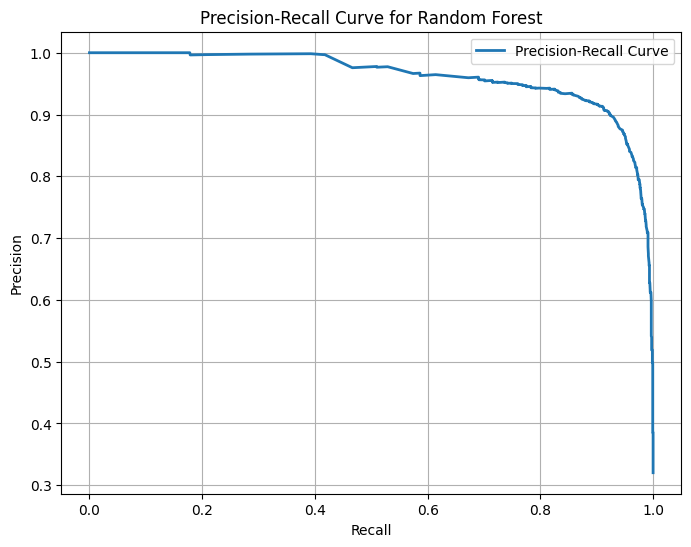

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Create and train the Random Forest classifier
forest_clf = RandomForestClassifier(random_state=42)

# Get cross-validated predictions
y_train_forest_pred = cross_val_predict(forest_clf, X_train_transformed, y_train, cv=3)

# Calculate and print the performance metrics
print("\n--- Random Forest Performance ---")
print(f"Precision: {precision_score(y_train, y_train_forest_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_forest_pred):.4f}")
print(f"F1 Score: {f1_score(y_train, y_train_forest_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_train, y_train_forest_pred):.4f}")

# Get the probabilities for the positive class (spam)
y_probas_forest = cross_val_predict(forest_clf, X_train_transformed, y_train, cv=3, method="predict_proba")

# Use probabilities for the positive class for the curve
y_scores_forest = y_probas_forest[:, 1]

# Calculate precision and recall for various thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_forest)

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, linewidth=2, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Random Forest")
plt.grid(True)
plt.legend()

### Comaparing Models

| **Model**                   | **Precision** | **Recall** | **F1-Score** | **ROC AUC** |
|:----------------------------|:-------------:|:----------:|:------------:|:-----------:|
| Logistic Regression         |     0.8946    |   0.9361   |    0.9149    |   0.9421    |
| SGDClassifier               |     0.8392    |   0.9290   |    0.8818    |   0.9226    |
| Multinomial Naive Bayes     |     0.9648    |   0.6535   |    0.7792    |   0.8212    |
| Random Forest Classifier    |     0.9087    |   0.9123   |    0.9105    |   0.9345    |

From the initial evaluation, **Logistic Regression** and **Random Forest** show comparable strong performance, with Logistic Regression having a slightly higher ROC AUC and a slightly better F1-score. **Multinomial Naive Bayes** achieved the highest precision but suffered significantly in recall, making it less balanced for this task. Therefore, **Logistic Regression** was selected as the final model for deployment due to its overall balance between precision and recall, along with its high ROC AUC.


### Parameter Tuning

I manually tuned the `vocabulary_size` parameter of the `WordCounterToVectorTransformer` to optimize the model's performance. The vocabulary sizes tested were **1000**, **2000**, **3500**, and **5000**, where **2000** provided the best performance. This tuning was crucial in preventing overfitting while ensuring that the model retained enough information to make accurate predictions.


### Final Evaluation

The ultimate measure of a model's effectiveness is its performance on completely unseen data. For this, the best model Logistic Regression was trained on the full training set and then evaluated on the dedicated test set. The results looked promising, however, the threshold for spam or not spam was adjusted to maximize the F1-Score, which is particularly important in spam classification to balance false positives and false negatives.

In [75]:
# Fit the pipeline on the full training data
X_train_final = preprocess_pipeline.fit_transform(X_train)

# Train the final classifier
final_clf = LogisticRegression(random_state=42, max_iter=2000)
final_clf.fit(X_train_final, y_train)

# Transform the test data and get prediction probabilities
X_test_transformed = preprocess_pipeline.transform(X_test)
y_test_probas = final_clf.predict_proba(X_test_transformed)[:, 1]

# Apply the optimal threshold found previously to make predictions
y_test_pred_optimised = (y_test_probas >= best_threshold).astype(int)

# Final evaluation with the optimized threshold
print("\n--- Final Model Performance on Test Set (F1-Optimized Threshold) ---")
print(f"Precision: {precision_score(y_test, y_test_pred_optimised):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_optimised):.4f}")
print(f"F1 Score: {f1_score(y_test, y_test_pred_optimised):.4f}")


--- Final Model Performance on Test Set (F1-Optimized Threshold) ---
Precision: 0.9347
Recall: 0.9454
F1 Score: 0.9400


### Conclusion
This project successfully developed a spam classifier using a supervised learning approach. The robust data preparation pipeline, including custom transformers for text cleaning, URL/number replacement, stemming, and stop word removal, proved highly effective in converting raw email data into a suitable format for machine learning.

The Logistic Regression classifier, after initial evaluation, demonstrated strong performance, achieving a Precision of 0.9347 and a Recall of 0.9454 on the unseen test set. This indicates that the model is highly effective at identifying spam emails while minimizing the misclassification of legitimate emails.
